# Exploratory Analysis on Missing Data

In [1]:
from pathlib import Path
import pandas as pd
import os
wd = Path.cwd().parent
path_to_data = [[wd / "input" / "rosenborg-women_a_2020.xlsx", wd / "input" / "rosenborg-women_a_2021.xlsx"],
                [wd / "input" / "vifwomen_a_2020.xlsx", wd / "input" / "vifwomen_a_2021.xlsx"]]
os.chdir(Path.cwd().parent)
from preprocessing.data_loader import generate_teams
from singular_spectrum_analysis.ssa_algorithm import SSA, diagonal_averaging, get_trajectory_matrix
import matplotlib.pyplot as plt
import numpy as np
from singular_spectrum_analysis.ssa_algorithm import get_trajectory_matrix
from fancyimpute import SoftImpute, KNN

(CVXPY) Feb 15 10:11:52 AM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/anaconda3/envs/soccer-sensor/lib/python3.8/site-packages/_scs_direct.cpython-38-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /anaconda3/envs/soccer-sensor/lib/python3.8/site-packages/scs/.dylibs/libgomp.1.dylib\n  Expected in: /usr/lib/libSystem.B.dylib\n in /anaconda3/envs/soccer-sensor/lib/python3.8/site-packages/scs/.dylibs/libgomp.1.dylib')


## Load in Soccer Data

In [2]:
teams = generate_teams(path_to_data, ["VI", "Rosenborg"])
players = teams["Rosenborg"].players

In [3]:
all_series=[]
for player in players.values():
    all_series.append(player.readiness)
average = pd.DataFrame(all_series).mean(axis=0).dropna()
team_ts = average.to_numpy()[:-20]


## Extent of Missing Data

In [4]:
nan_signal = []
for player in players.values():
    for attr in player.__dataclass_fields__:
        attribute = getattr(player, attr)
        if isinstance(attribute, pd.Series):
            nan_signal.append(attribute.isna().sum()/ len(attribute))
    
    

In [5]:
nr_missing_data = []
for player in players.values():
    readiness = player.readiness.isna().sum()/len(player.readiness)
    soreness = player.soreness.isna().sum()/len(player.soreness)
    stress = player.stress.isna().sum()/len(player.stress)
    fatique = player.fatigue.isna().sum()/len(player.fatigue)
    mood = player.mood.isna().sum()/len(player.mood)
    sleep_dur = player.sleep_duration.isna().sum()/len(player.sleep_duration)
    sleep_qual = player.sleep_quality.isna().sum()/len(player.sleep_quality)
    nr_missing_data.append(np.mean([readiness, soreness, stress, fatique, mood, sleep_dur, sleep_qual]))

#missing_data_per_player = [value/total_data_per_player for value in nr_missing_data]
missing_data_per_player = nr_missing_data

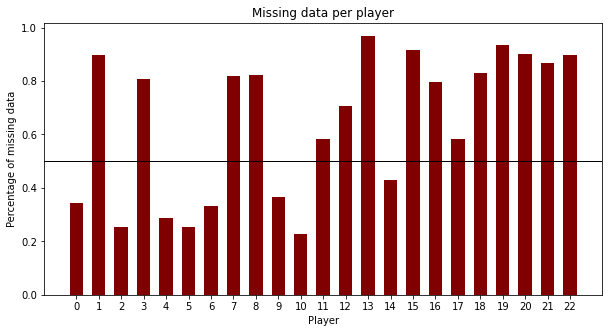

In [6]:
fig = plt.figure(figsize = (10, 5))

plt.bar(players.keys(), missing_data_per_player, color ='maroon',
        width = 0.6)
plt.axhline(y=0.5,linewidth=1, color='k')
plt.xlabel("Player")
plt.ylabel("Percentage of missing data")
plt.title("Missing data per player")
plt.show()

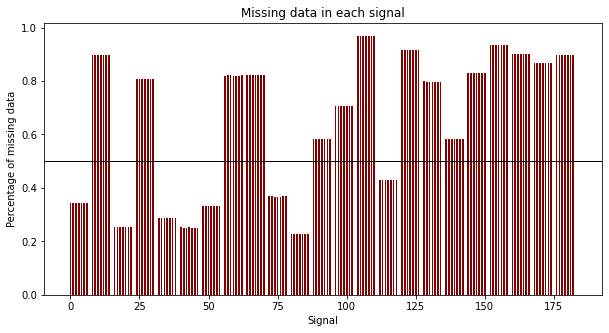

In [7]:
fig = plt.figure(figsize = (10, 5))

plt.bar(range(0,len(nan_signal)), nan_signal, color ='maroon',
        width = 0.6)
plt.axhline(y=0.5,linewidth=1, color='k')
plt.xlabel("Signal")
plt.ylabel("Percentage of missing data")
plt.title("Missing data in each signal")
plt.show()

In [153]:
%%capture
traject = SSA.fit(ts_soft_impute, lag=500, order=14, threshold=0.01, total_iterations=100)
softimpute_transformed = diagonal_averaging(SoftImpute().fit_transform(get_trajectory_matrix(players["16"].readiness, lag=500)))
transformed_readiness = diagonal_averaging(traject.trajectory_matrix)

Iteration0
Iteration50
[SoftImpute] Max Singular Value of X_init = 773.606275
[SoftImpute] Iter 1: observed MAE=0.887951 rank=214
[SoftImpute] Iter 2: observed MAE=0.871031 rank=190
[SoftImpute] Iter 3: observed MAE=0.838040 rank=166
[SoftImpute] Iter 4: observed MAE=0.803332 rank=142
[SoftImpute] Iter 5: observed MAE=0.760169 rank=115
[SoftImpute] Iter 6: observed MAE=0.721767 rank=98
[SoftImpute] Iter 7: observed MAE=0.694984 rank=83
[SoftImpute] Iter 8: observed MAE=0.663130 rank=65
[SoftImpute] Iter 9: observed MAE=0.634296 rank=48
[SoftImpute] Iter 10: observed MAE=0.610406 rank=38
[SoftImpute] Iter 11: observed MAE=0.593748 rank=33
[SoftImpute] Iter 12: observed MAE=0.578044 rank=26
[SoftImpute] Iter 13: observed MAE=0.565790 rank=22
[SoftImpute] Iter 14: observed MAE=0.556977 rank=20
[SoftImpute] Iter 15: observed MAE=0.552009 rank=20
[SoftImpute] Iter 16: observed MAE=0.550781 rank=18
[SoftImpute] Iter 17: observed MAE=0.551012 rank=16
[SoftImpute] Iter 18: observed MAE=0.55198

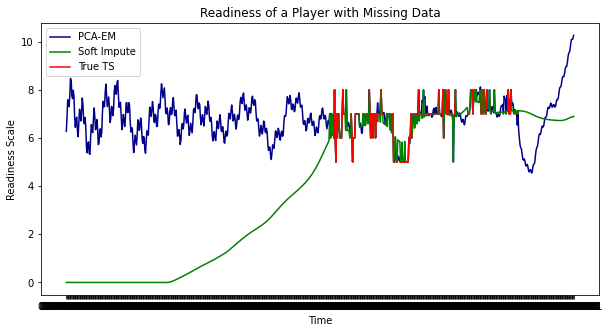

In [155]:
fig = plt.figure(figsize = (10, 5))
plt.plot(transformed_readiness, color="darkblue", label="PCA-EM")
plt.plot(softimpute_transformed, color="green", label="Soft Impute")
plt.plot(players["16"].readiness, color="red", label= "True TS")
plt.title("Readiness of a Player with Missing Data")
plt.xlabel("Time")
plt.ylabel("Readiness Scale")
plt.legend()

### Load in Evaluation Data

In [81]:
birth_ts = pd.read_csv(wd/"notebooks"/"birth_data.csv", sep = ";")

In [13]:
from random import shuffle
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Evaluate on Team TS

In [65]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
mean_impute_data = []
pca_mae = []
softimpute_mae = []
meanimpute_mae = []
knn_impute_mae = []

for iteration in range(0,10):
    edge_nans = [np.nan for _ in range(50)]
    missing_middle = [np.nan if 1.5 < np.random.normal(1, 1, 1)[0] else 0 for i in range(500)]
    
    mask = [edge_nans, missing_middle, edge_nans, edge_nans]
    shuffle(mask)
    flat_list = [item for sublist in mask for item in sublist]

    supervised_series = np.array(team_ts+flat_list)
    mean_impute = pd.Series(supervised_series).fillna(np.nanmean(supervised_series))
    mean_impute_data.append(mean_impute)

    trajectory_matrix = get_trajectory_matrix(supervised_series,300)
    softimpute_series = diagonal_averaging(SoftImpute().fit_transform(trajectory_matrix))
    sotimpute_data.append(softimpute_series)

    traject = SSA.fit(supervised_series, lag=300, order=10, threshold=0.01, total_iterations=300)
    pca_res = diagonal_averaging(traject.trajectory_matrix)
    pca_data.append(pca_res)
    
    knn_imputed = diagonal_averaging(KNN().fit_transform(trajectory_matrix))
    knn_data.append(knn_imputed)
    
        
    pca_mae.append(mean_absolute_error(team_ts, pca_res))
    softimpute_mae.append(mean_squared_error(team_ts, softimpute_series))
    meanimpute_mae.append(mean_squared_error(team_ts, mean_impute))
    knn_impute_mae.append(mean_squared_error(team_ts, knn_imputed))

In [66]:
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for MeanImpute", np.mean(meanimpute_mae))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

Average MAE for PCA-EM 0.25192654622085675
Average MAE for SoftImpute 0.19700291276106086
Mean MAE for MeanImpute 0.16853809369447917
Mean MAE for KNN Impute 0.18598311683088398


In [37]:
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for MeanImpute", np.mean(meanimpute_mae))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

Average MAE for PCA-EM 0.21097768299489736
Average MAE for SoftImpute 0.1787098201117441
Mean MAE for MeanImpute 0.15580346079946333
Mean MAE for KNN Impute 0.17814628357421106


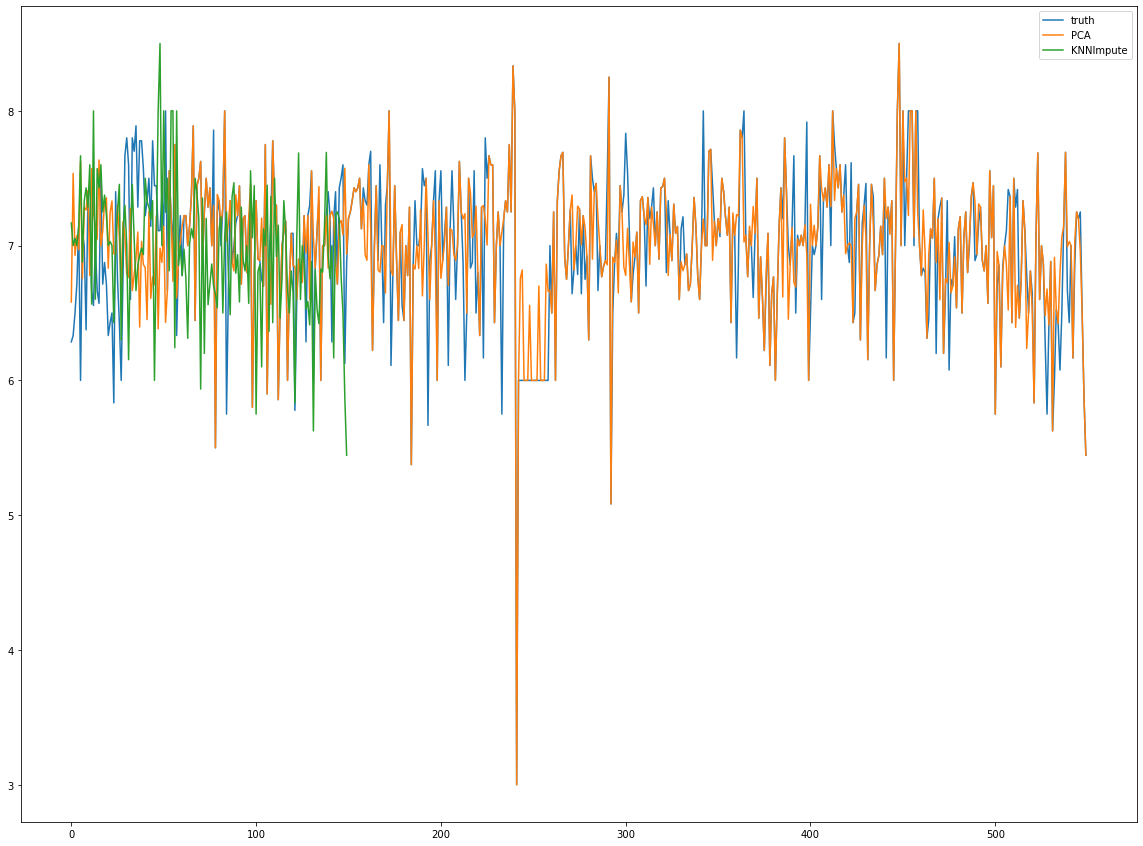

In [68]:
fig = plt.figure(figsize = (20, 15))
plt.plot(team_ts[100:],  label="truth")
plt.plot(pca_data[2][100:], label="PCA")
#plt.plot(sotimpute_data[2][100:], label ="Softimpute")
#plt.plot(mean_impute_data[2][500:], label ="MeanImpute")
plt.plot(knn_data[2][500:], label ="KNNImpute")

plt.legend()

### Correlation between Real and Imputed TS

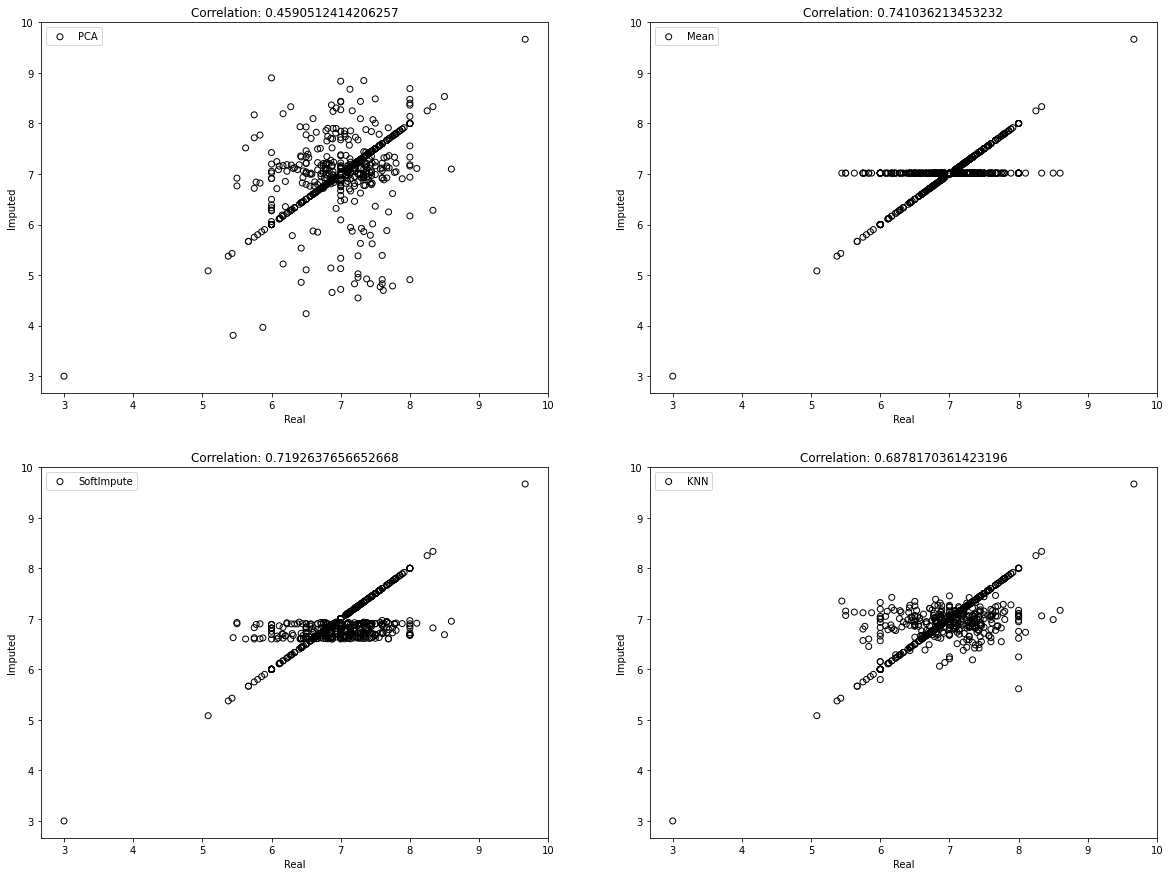

In [69]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(team_ts,pca_data[1], label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(team_ts, pca_data[1])[0,1]}')
ax1.legend()
ax2.scatter(team_ts, pd.Series(mean_impute_data[1]), label="Mean", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: {np.corrcoef(team_ts, mean_impute_data[1])[0,1]}')
ax2.legend()
ax3.scatter(team_ts, sotimpute_data[1], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: {np.corrcoef(team_ts, sotimpute_data[1])[0,1]}')
ax3.legend()
ax4.scatter(team_ts, knn_data[1], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(team_ts, knn_data[1])[0,1]}')
ax4.legend()

### Autocorrelation

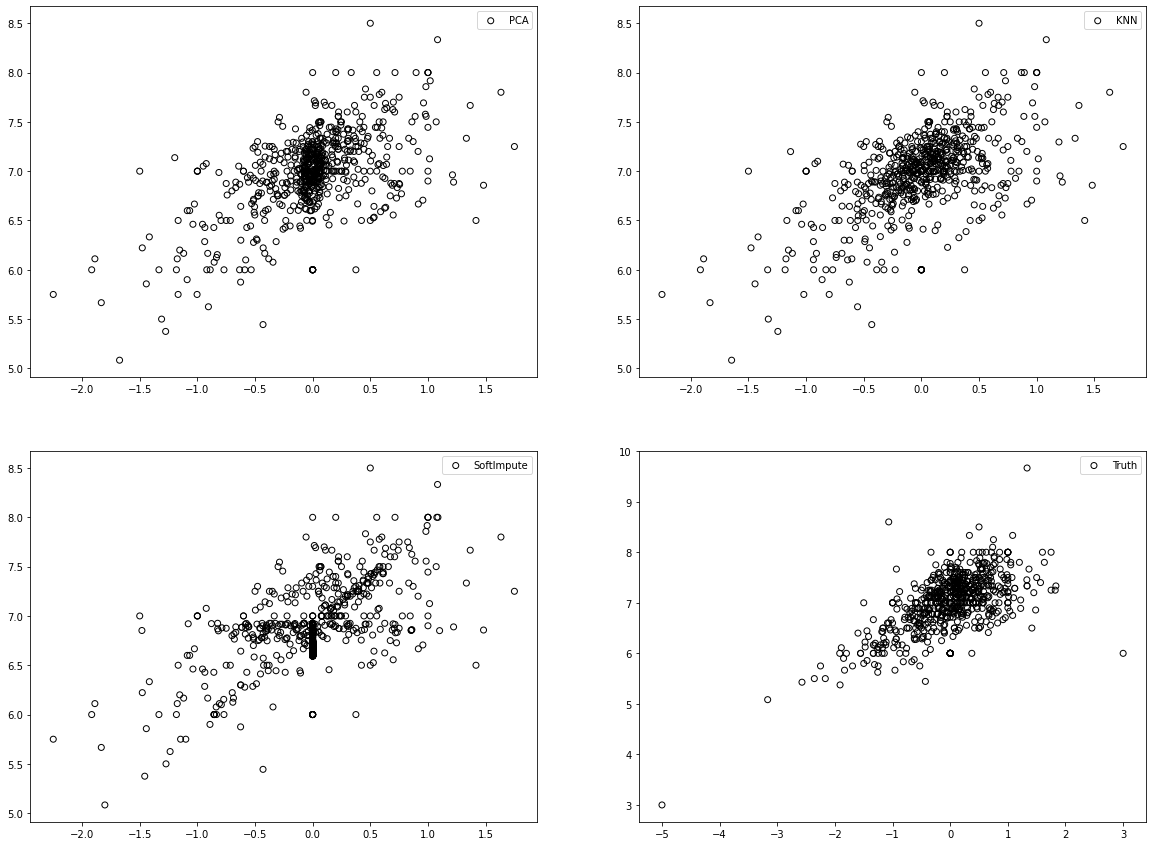

In [25]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(pd.Series(pca_data[1]).diff(), pd.Series(pca_data[1]), label="PCA", facecolors='none', edgecolors='black')
ax1.legend()
ax2.scatter(pd.Series(knn_data[1]).diff(), pd.Series(knn_data[1]), label="KNN", facecolors='none', edgecolors='black')
ax2.legend()
ax3.scatter(pd.Series(sotimpute_data[1]).diff(), pd.Series(sotimpute_data[1]), label="SoftImpute", facecolors='none', edgecolors='black')
ax3.legend()
ax4.scatter(pd.Series(team_ts).diff(), pd.Series(team_ts), label="Truth", facecolors='none', edgecolors='black')
ax4.legend()

#plt.plot(sotimpute_data[2], label ="Softimpute")
#plt.plot(mean_impute_data[2], label ="MeanImpute")

## Evaluate on Birth Data

In [169]:
%%capture
sotimpute_data = []
knn_data = []
pca_data = []
mean_impute_data = []
pca_mae = []
softimpute_mae = []
meanimpute_mae = []
knn_impute_mae = []

for iteration in range(0,10):
    edge_nans = [np.nan for _ in range(65)]
    missing_middle = [np.nan if 1.0 < np.random.normal(1, 1, 1)[0] else 0 for i in range(235)]
    
    mask = [edge_nans, missing_middle, edge_nans]
    shuffle(mask)
    flat_list = [item for sublist in mask for item in sublist]

    supervised_series = np.array(birth_ts["Births"].to_numpy()+flat_list)
    mean_impute = pd.Series(supervised_series).fillna(np.nanmean(supervised_series))
    mean_impute_data.append(mean_impute)

    trajectory_matrix = get_trajectory_matrix(supervised_series,31)
    softimpute_series = diagonal_averaging(SoftImpute().fit_transform(trajectory_matrix))
    sotimpute_data.append(softimpute_series)

    traject = SSA.fit(supervised_series, lag=30, order=10, threshold=0.1, total_iterations=250)
    pca_res = diagonal_averaging(traject.trajectory_matrix)
    pca_data.append(pca_res)
    
    knn_imputed = diagonal_averaging(KNN().fit_transform(trajectory_matrix))
    knn_data.append(knn_imputed)
    
        
    pca_mae.append(mean_absolute_error(birth_ts["Births"].to_numpy(), pca_res))
    softimpute_mae.append(mean_squared_error(birth_ts["Births"].to_numpy(), softimpute_series))
    meanimpute_mae.append(mean_squared_error(birth_ts["Births"].to_numpy(), mean_impute))
    knn_impute_mae.append(mean_squared_error(birth_ts["Births"].to_numpy(), knn_imputed))

In [171]:
print("Order 10")
print("Average MAE for PCA-EM",np.mean(pca_mae))
print("Average MAE for SoftImpute",np.mean(softimpute_mae))
print("Mean MAE for MeanImpute", np.mean(meanimpute_mae))
print("Mean MAE for KNN Impute", np.mean(knn_impute_mae))

Order 10
Average MAE for PCA-EM 6.425124967051128
Average MAE for SoftImpute 578.5476508816611
Mean MAE for MeanImpute 40.19680630417945
Mean MAE for KNN Impute 558.0750976336328


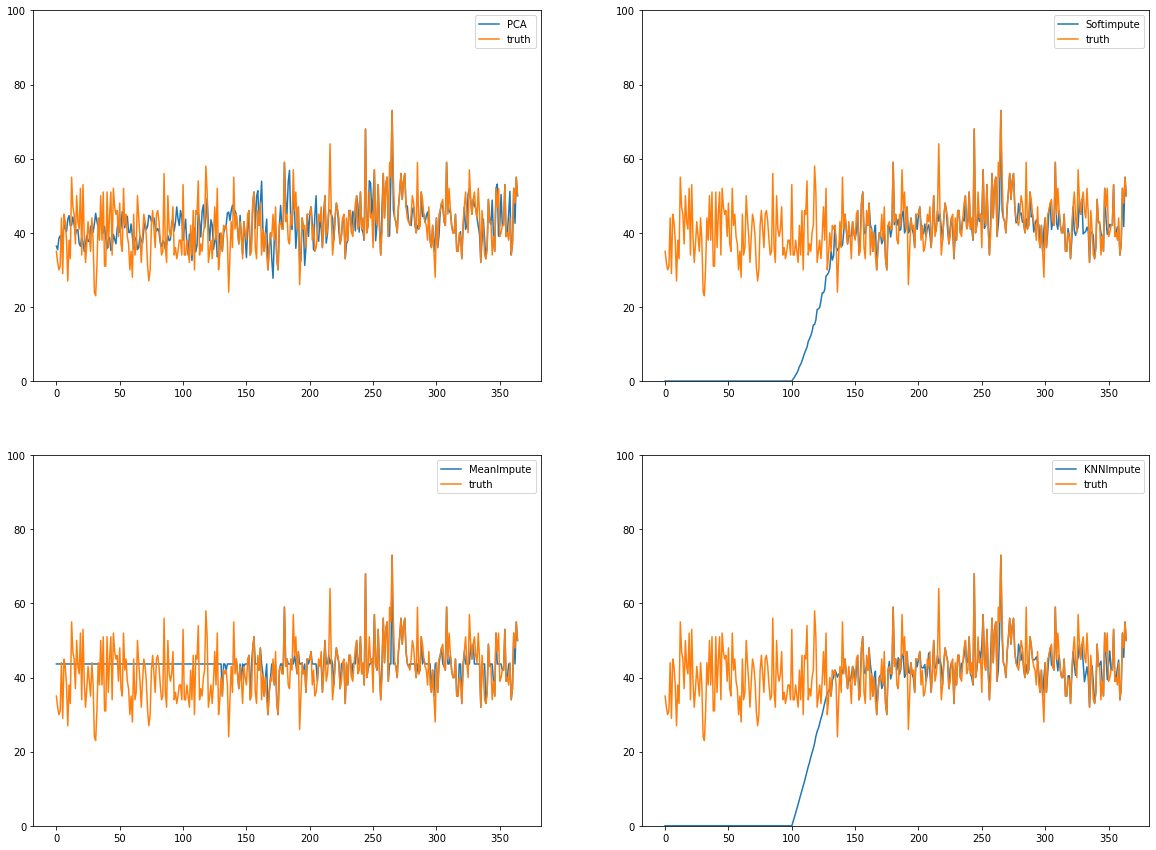

In [192]:
fig, ((ax1,ax2),(ax3, ax4))= plt.subplots(2,2,figsize = (20, 15))
ax1.plot(pca_data[2], label="PCA")
ax1.plot(birth_ts["Births"].to_numpy(),  label="truth")
ax1.set_ylim(0,100)
ax1.legend()

ax2.plot(sotimpute_data[2], label ="Softimpute")
ax2.plot(birth_ts["Births"].to_numpy(),  label="truth")
ax2.set_ylim(0,100)

ax2.legend()

ax3.plot(mean_impute_data[2], label ="MeanImpute")
ax3.plot(birth_ts["Births"].to_numpy(),  label="truth")
ax3.set_ylim(0,100)

ax3.legend()


ax4.plot(knn_data[2], label ="KNNImpute")
ax4.plot(birth_ts["Births"].to_numpy(),  label="truth")
ax4.set_ylim(0,100)
ax4.legend()

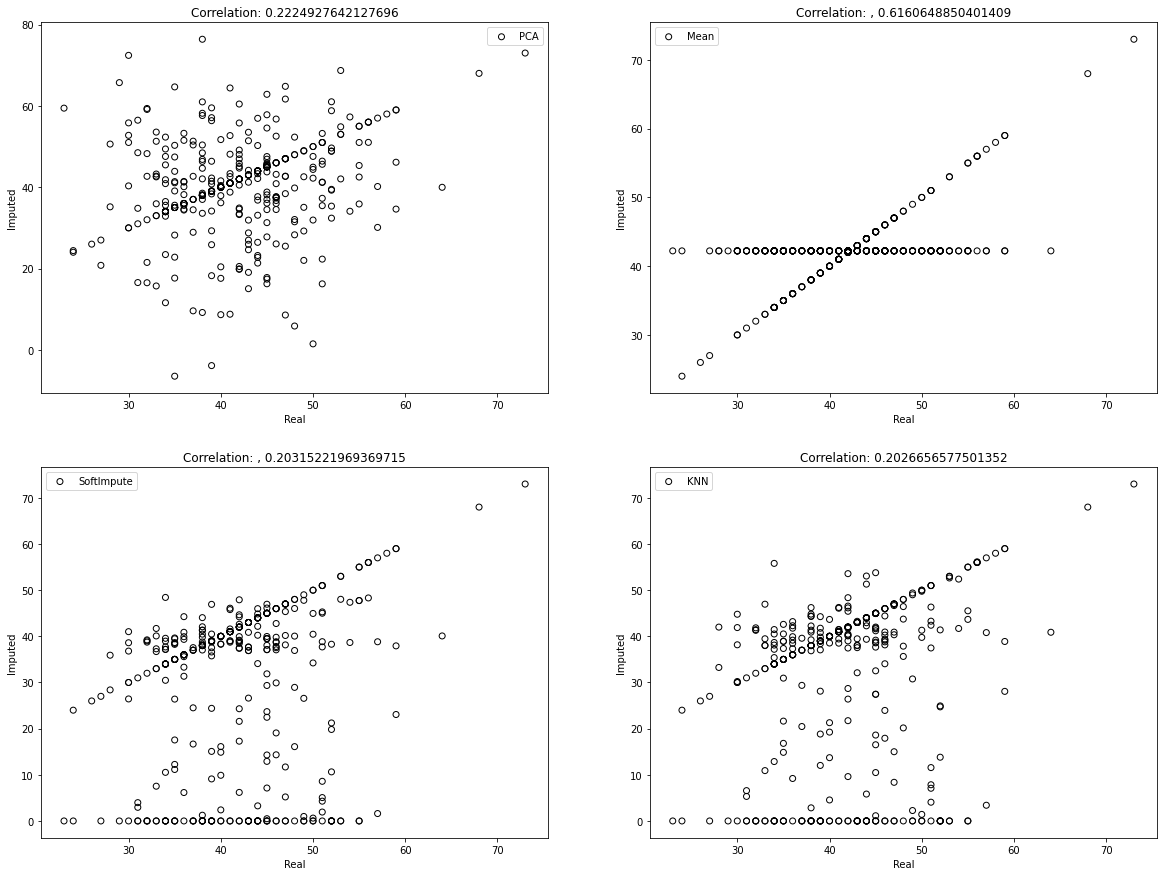

In [173]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(2, 2, figsize = (20, 15))
ax1.scatter(birth_ts["Births"],pca_data[1],label="PCA", facecolors='none', edgecolors='black')
ax1.set_xlabel("Real")
ax1.set_ylabel("Imputed")
ax1.set_title(f'Correlation: {np.corrcoef(birth_ts["Births"].to_numpy(), pca_data[1])[0,1]}')
ax1.legend()
ax2.scatter(birth_ts["Births"], pd.Series(mean_impute_data[1]), label="Mean", facecolors='none', edgecolors='black')
ax2.set_xlabel("Real")
ax2.set_ylabel("Imputed")
ax2.set_title(f'Correlation: , {np.corrcoef(birth_ts["Births"].to_numpy(), mean_impute_data[1])[0,1]}')
ax2.legend()
ax3.scatter(birth_ts["Births"], sotimpute_data[1], label="SoftImpute", facecolors='none', edgecolors='black')
ax3.set_xlabel("Real")
ax3.set_ylabel("Imputed")
ax3.set_title(f'Correlation: , {np.corrcoef(birth_ts["Births"].to_numpy(), sotimpute_data[1])[0,1]}')
ax3.legend()
ax4.scatter(birth_ts["Births"], knn_data[1], label="KNN", facecolors='none', edgecolors='black')
ax4.set_xlabel("Real")
ax4.set_ylabel("Imputed")
ax4.set_title(f'Correlation: {np.corrcoef(birth_ts["Births"].to_numpy(), knn_data[1])[0,1]}')
ax4.legend()